# Method to analyze whether SNV in ETS

In [1]:
import scipy.stats as stats
import sigfig as sf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import time
import pickle
import os

import helper_functions as hf

In [2]:
tfName='AP1'
expName='Kircher'

In [3]:
tfCore='NTKANNMA'

tfAll8mersPossible=hf.IupacToAllPossibleSequences(tfCore)
tfAll8mersPossible+=[hf.revcomp(seq) for seq in tfAll8mersPossible]

In [4]:
def getAll8mers(seq,p,ref,alt):
    
    altLenAdj=len(ref)-len(alt)
        
    if altLenAdj==0:
        seq=seq[p-7:p+8]    
        seqRef=seq[:7]+ref+seq[7+1:]
        seqAlt=seq[:7]+alt+seq[7+1:]
        
    elif altLenAdj>0:
        seq=seq[p-7:p+8+altLenAdj]    
        seqRef=seq[:7]+ref+seq[7+1:-altLenAdj]
        seqAlt=seq[:7]+alt+seq[7+1:]
    else:
        raise ValueError('ref/alt not allowed yet')
    
    # if len(seqRef)!=len(seqAlt):
        # raise ValueError('ref/alt seqs not dovetailed')
        
    for i,end in enumerate(range(7,len(seq)-altLenAdj)):
        start=end-7
        last=end+1
        kmer8Ref=seqRef[start:last]
        kmer8Alt=seqAlt[start:last]
            
        yield kmer8Ref,kmer8Alt
                    #.  012345678901234567890
            
# for i in getAll8mers(chr2seq['chr7'], 156791183, 'T', ''):
    # print(i)
            

In [5]:
def is_tf_8mer(kmer8):
    if kmer8 in tfAll8mersPossible:                    return True
    else:                                      return False

# Set up logic for creating/deleting ets sites
BeforeAfter2TfLogic={
    (0,0):'Tf Never',
    (1,1):'Tf Always',
    (0,1):'Tf Created',
    (1,0):'Tf Deleted'
}

In [6]:

def snv_ets_analysis(chrom,idx1,ref,alt,chr2seq,tf2aff):
    
    # Ensure data is snp, no indels
    prohibitedPolyTypes=['Other']
    if len(ref)==1 and len(alt)==1: 
        polymorphismType='SNV'
        
    elif len(ref)==1 and len(alt)==0:
        polymorphismType='SND'
        
    else:
        polymorphismType='Other'
        
    if polymorphismType in prohibitedPolyTypes:
        return 'Variant Type Not Allowed Yet'
        
    ######################################
    # Verify ref/alt matches genomic bp
    ######################################
    
    if 'chr' not in chrom: chrom=f'chr{chrom}'
    
    # Check if pos in genome is same as declared REF
    idx0=int(idx1)-1
    snvNtInGenome=chr2seq[chrom][idx0]
    if ref==snvNtInGenome:    
        checkSnv='REF'
    elif alt==snvNtInGenome:  
        checkSnv='ALT'
    else:                     
        return f'Genomic bp does not match expectation: \n  expected ref/alt = ({ref}/{alt})\n  observed = {snvNtInGenome}'
    
    
    ######################################
    # Assess if SNV is in ETS
    ######################################
    
    tfChanged=False
    for kmer8,kmer8mut in getAll8mers(chr2seq[chrom],idx0,ref,alt):

        ba=(is_tf_8mer(kmer8),is_tf_8mer(kmer8mut)) # before after logic
        tfLogic=BeforeAfter2TfLogic[ba]

        # If ets-changing snp found, write it out
        if tfLogic=='Tf Always': 
            tfChanged=True
            refaff=tf2aff[kmer8]
            altaff=tf2aff[kmer8mut]
            
            return tfLogic,refaff,altaff,altaff/refaff,kmer8,kmer8mut
        
        elif tfLogic=='Tf Created':
            return tfLogic,kmer8,kmer8mut
            
        elif tfLogic=='Tf Deleted':
            return tfLogic,kmer8,kmer8mut

    if tfChanged==False:
        return 'Variant not in Tf',kmer8,kmer8mut



# Load ref data

In [7]:
ref  =f'preprocessed-data/parsed_Jun_Fos_8mers_core=TGANTMA_max=TGAGTCAT.txt'
Seq2TfAff  = hf.loadAff(ref)
hf.dprint(Seq2TfAff)


# hg38
ref='/Users/joe/code/ref/genomes/human/hg38/fasta/hg38.fa'
chr2seq=hf.faLoadGenome(ref)

AAAAAAAC 0.28640095325611686


# Load MPRA data

In [8]:
fn='preprocessed-data/kircher-hg38-allens-nodels-correctPvals=True.tsv'
df=pd.read_csv(fn,sep='\t')
df.head(2)

,cse,chrom,pos,ref,alt,effect,p-value,Element
0,chr2_60494940_C_A,chr2,60494940,C,A,-0.05,0.591536,BCL11A
1,chr2_60494940_C_G,chr2,60494940,C,G,-0.13,0.289893,BCL11A


In [9]:

enhancersToPlot=[]
variantTypeList=[]
refAffList=[]
altAffList=[]
fcList=[]
ref8merlist=[]
alt8merlist=[]

for idx in df.index:
    
    chrom,pos,ref,alt,element=[df.at[idx,ci] for ci in ['chrom','pos','ref','alt','Element']]

    if alt=='-': alt=''
    resultList=snv_ets_analysis(chrom,pos,ref,alt,chr2seq,Seq2TfAff)
    result=resultList[0]
    
    if result=='Variant not in Tf':
        result,kmer8,kmer8mut=resultList
        variantTypeList.append('Not In Tf')
        refAffList.append(np.NaN)
        altAffList.append(np.NaN)
        fcList.append(np.NaN)
        ref8merlist.append(kmer8)
        alt8merlist.append(kmer8mut)
        enhancersToPlot.append(element)

    elif result=='Tf Created':
        result,kmer8,kmer8mut=resultList
        variantTypeList.append('Tf Created')
        refAffList.append(np.NaN)
        altAffList.append(np.NaN)
        fcList.append(np.NaN)
        ref8merlist.append(kmer8)
        alt8merlist.append(kmer8mut)
        enhancersToPlot.append(element)

    elif result=='Tf Deleted':
        result,kmer8,kmer8mut=resultList
        variantTypeList.append('Tf Deleted')
        refAffList.append(np.NaN)
        altAffList.append(np.NaN)
        fcList.append(np.NaN)
        ref8merlist.append(kmer8)
        alt8merlist.append(kmer8mut)
        enhancersToPlot.append(element)
        
    else:
        variantType,refAff,altAff,fc,kmer8ref,kmer8alt=resultList
        variantTypeList.append(variantType)
        refAffList.append(refAff)
        altAffList.append(altAff)
        fcList.append(fc)
        ref8merlist.append(kmer8ref)
        alt8merlist.append(kmer8alt)
        enhancersToPlot.append(element)
        
        
    
    

In [10]:
df['variant-type']=variantTypeList
df['aff-ref']=refAffList
df['aff-alt']=altAffList
df['aff-fc']=fcList
df['kmer-ref']=ref8merlist
df['kmer-alt']=alt8merlist

In [11]:
# replace p values of 0 with minimum p value detected in experiment to log transform 
sortedPList=sorted(set(df['p-value'].tolist()))
print(sortedPList[:3])

minNonzeroP=sortedPList[1]
print(minNonzeroP)

df['p-value']=df['p-value'].replace(0,minNonzeroP)
print(min(df['p-value']))

[0.0, 5.910378607360339e-05, 0.0001147590284025]
5.910378607360339e-05
5.910378607360339e-05


In [12]:
df['-log(p)']=df['p-value'].apply(lambda p: -np.log10(p))
df['-log(p)*direction']=df.apply(lambda r: r['-log(p)'] if r['effect']>=0 else -r['-log(p)'],axis=1)

In [13]:
df['variant-type'].value_counts()

Not In Tf     35622
Tf Deleted     1346
Tf Always      1145
Tf Created     1057
Name: variant-type, dtype: int64

# Violin plots for nature

In [14]:
enhancersToPlot=[
'BCL11A',
'IRF4',
'IRF6',
'MYCrs11986220',
'MYCrs6983267',
'RET',
'TCF7L2',
'UC88',
'ZFAND3',
'SORT1',
'ZRSh-13h2']

In [15]:
pvalCutoff=.05

deNovoThresh=.25

fcOptCutoff=1.5
fcDecCutoff=sf.round(1/fcOptCutoff,3)

fcNoChangeCutoff_Inc=1.25
fcNoChangeCutoff_Dec=sf.round(1/fcNoChangeCutoff_Inc,3)


for zrsList in [enhancersToPlot]:
    
    print(zrsList)
    logSigCutoff=abs(np.log10(pvalCutoff))

    # get variants to predict on
    predDF=df.loc[df.Element.isin(zrsList),:]

    # assign prediction labels
    bins=[-np.inf,-logSigCutoff,logSigCutoff,np.inf]
    predDF['classification']=pd.cut(predDF['-log(p)*direction'],bins=bins,labels=['Sig Decrease','N.S.','Sig Increase'])

    # assign predictions
    etsLabels=[]

    for fc,classification,kmer,kmerMut in hf.zipdf(predDF,['aff-fc','variant-type','kmer-ref','kmer-alt']):

        # not in tf
        if classification=='Not In Tf':
            anno='not-in-tf'

        # delet tf
        elif classification=='Tf Deleted':
            anno='del-tf'

        elif classification=='Tf Created':

            denovoaff=Seq2TfAff[kmerMut]

            if denovoaff<deNovoThresh:
                anno=f'de-novo-tf-low-aff\n<{deNovoThresh}'            

            elif denovoaff>=deNovoThresh:
                anno=f'de-novo-tf-high-aff\n>={deNovoThresh}'

        #  dramatic iincrase
        elif fc>=fcOptCutoff:
            anno=f'dramatic-increase\n>={fcOptCutoff}'
            
        #  dramatic incrase
        elif fc<=fcDecCutoff:
            # print(fc,classification)
            anno=f'dramatic-decrease\n<={fcDecCutoff}'

        # no increase
        elif fc<=fcNoChangeCutoff_Inc and fc>=fcNoChangeCutoff_Dec:
            anno=f'no-change-aff\n<={fcNoChangeCutoff_Inc}\n>={fcNoChangeCutoff_Dec}'

        else:
            # print(fc,classification,kmer,kmerMut)
            anno='subtle-change'


        etsLabels.append(anno)

    predDF['tf-class']=etsLabels

    line_out=hf.write_row(['snv-group','total','effect-ns','effect-gof','effect-lof'])

    for classi in predDF['tf-class'].unique():
        nClassi=predDF['tf-class'].value_counts()[classi]

        ns,gof,lof=[predDF.loc[predDF['tf-class']==classi,'classification'].value_counts()[ci] for ci in ['N.S.','Sig Increase','Sig Decrease']]

        line_out+=hf.write_row([classi,nClassi,ns,gof,lof])

    print(line_out)
    zrsId='+'.join(zrsList)
    with open(f'FOR-NATURE-STATS-PREDICTIONS-{tfName}-{zrsId}__fdr.tsv','w') as f: f.write(line_out)

/Users/joe/miniconda3/lib/python3.9/site-packages/sigfig/sigfig.py:586: UserWarning: warning: 3 significant figures requested from number with only 1 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))


['BCL11A', 'IRF4', 'IRF6', 'MYCrs11986220', 'MYCrs6983267', 'RET', 'TCF7L2', 'UC88', 'ZFAND3', 'SORT1', 'ZRSh-13h2']
snv-group	total	effect-ns	effect-gof	effect-lof
not-in-tf	16465	12050	1878	2537
de-novo-tf-high-aff
>=0.25	531	379	73	79
no-change-aff
<=1.25
>=0.8	527	378	70	79
del-tf	732	514	65	153
subtle-change	79	50	17	12
de-novo-tf-low-aff
<0.25	67	48	11	8
dramatic-increase
>=1.5	16	4	12	0
dramatic-decrease
<=0.667	10	5	1	4



/var/folders/r8/cnsr_ylj6qd449cvnpt46c6w0000gn/T/ipykernel_4500/2195329996.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predDF['classification']=pd.cut(predDF['-log(p)*direction'],bins=bins,labels=['Sig Decrease','N.S.','Sig Increase'])
/var/folders/r8/cnsr_ylj6qd449cvnpt46c6w0000gn/T/ipykernel_4500/2195329996.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predDF['tf-class']=etsLabels


group1	group2	p
not-in-tf+del-tf+dramatic-decrease <=0.667+de-novo-tf-low-aff <0.25+de-novo-tf-high-aff >=0.25+subtle-change	no-change-aff <=1.25 >=0.8	0.07389
not-in-tf+del-tf+dramatic-decrease <=0.667+de-novo-tf-low-aff <0.25+de-novo-tf-high-aff >=0.25+subtle-change	dramatic-increase >=1.5	8.092e-09



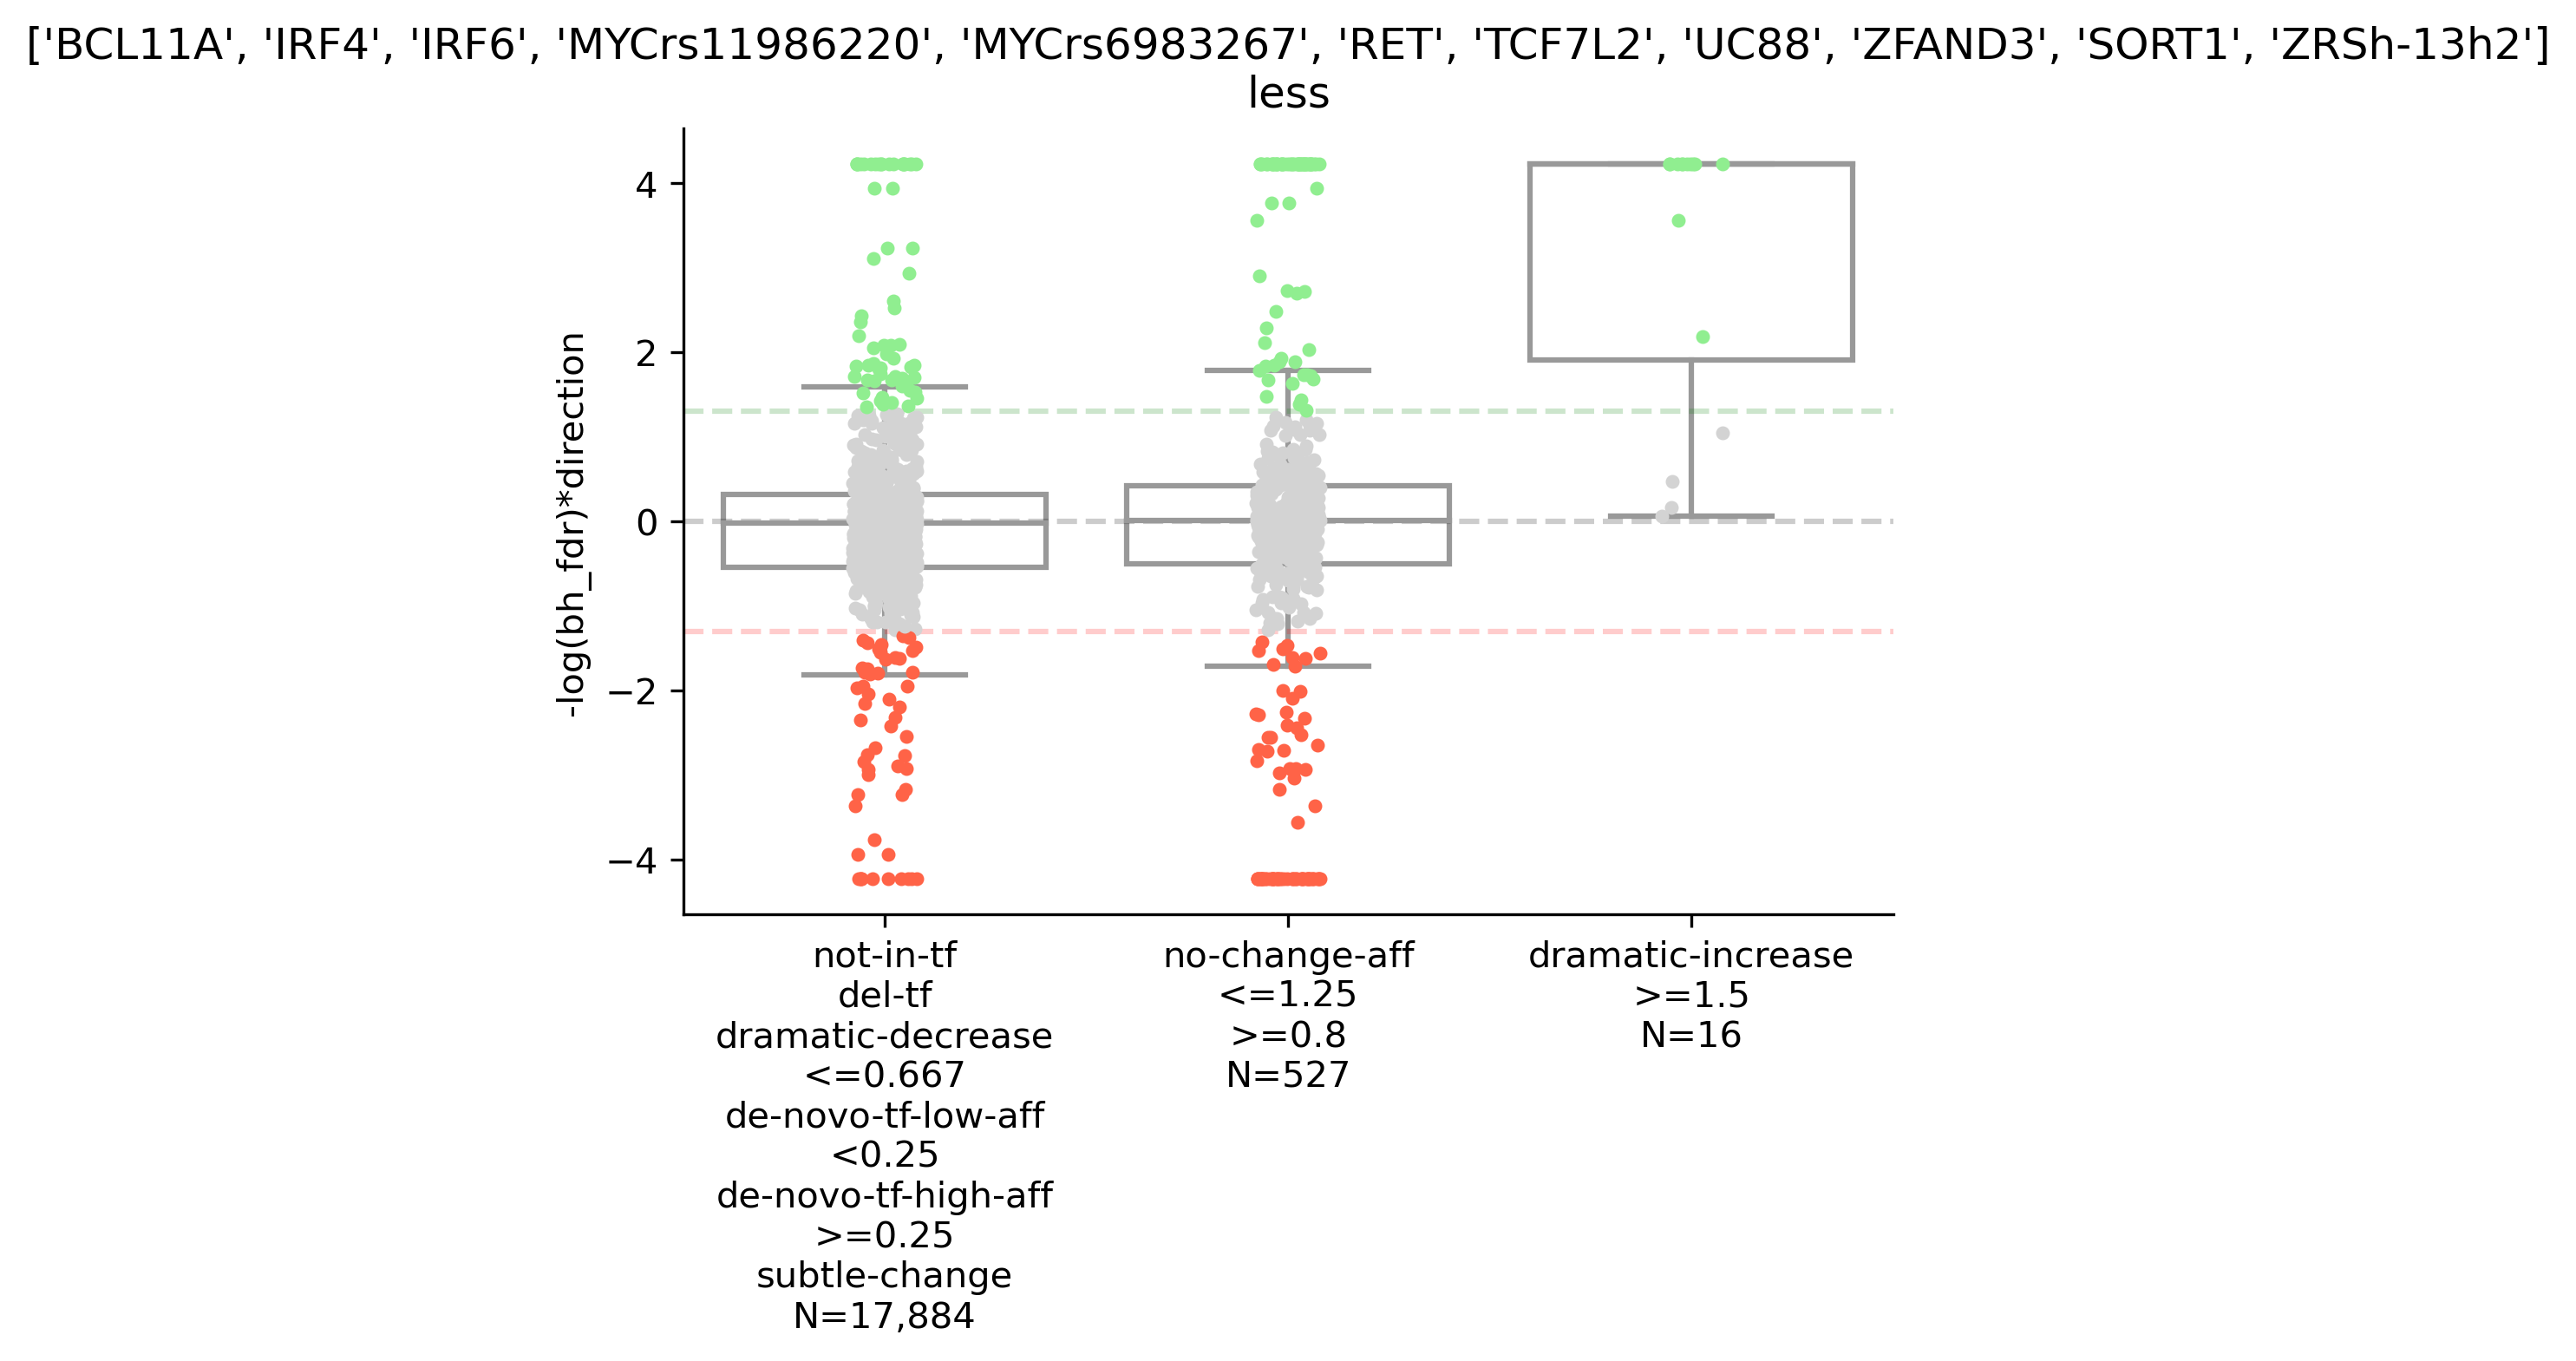

In [16]:
altHypothesis='less'
violin=False
boxplot=True

datalabels_subset_v2=[
[f'not-in-tf',f'del-tf',f'dramatic-decrease\n<={fcDecCutoff}',f'de-novo-tf-low-aff\n<{deNovoThresh}',f'de-novo-tf-high-aff\n>={deNovoThresh}','subtle-change'],
[f'no-change-aff\n<={fcNoChangeCutoff_Inc}\n>={fcNoChangeCutoff_Dec}'],
[f'dramatic-increase\n>={fcOptCutoff}'],
]

data2color={
(f'no-change-aff\n<={fcNoChangeCutoff_Inc}\n>={fcNoChangeCutoff_Dec}',):'lightgrey',
(f'dramatic-increase\n>={fcOptCutoff}',):'forestgreen',
(f'not-in-tf',f'del-tf',f'dramatic-decrease\n<={fcDecCutoff}',f'de-novo-tf-low-aff\n<{deNovoThresh}',f'de-novo-tf-high-aff\n>={deNovoThresh}','subtle-change'):'dimgrey'}



plotDF=predDF.loc[predDF.Element.isin(enhancersToPlot),:]

data=[]
for di in datalabels_subset_v2:
    datai=[]
    for dj in di:
        datai+=plotDF.loc[(plotDF['tf-class']==dj),'-log(p)*direction'].tolist()
    data.append(datai)

line_out=hf.write_row(['group1','group2','p'])

############################################################################
# Stats
############################################################################

dCtrlNameList=datalabels_subset_v2[0]
dCtrl=plotDF.loc[(plotDF['tf-class'].isin(dCtrlNameList)),'-log(p)*direction']

for diNameList in datalabels_subset_v2[1:]:

    di=plotDF.loc[(plotDF['tf-class'].isin(diNameList)),'-log(p)*direction']

    try:
        _ , p =stats.mannwhitneyu(dCtrl,di,alternative=altHypothesis)
    except ValueError:
        pass


    line_out+=hf.write_row(['+'.join(dCtrlNameList).replace('\n',' '),'+'.join(diNameList).replace('\n',' '),sf.round(p,4)])

print(line_out)
sampleName='+'.join(enhancersToPlot)
with open(f'FOR-NATURE__violin-stats__{tfName}__{sampleName}.tsv','w') as f: f.write(line_out)

############################################################################
# Stats
############################################################################

fig,ax=hf.quickfig(2*len(datalabels_subset_v2),4,dpi=300)

palette=[data2color[tuple(di)] for di in datalabels_subset_v2]

if violin:
    sns.violinplot(data=data,color='white',inner=None,cut=0,ax=ax,width=1.1,scale='area')

if boxplot:
    sns.boxplot(data=data,color='white',ax=ax,fliersize=0)#,palette=palette)

lc=0
for xi,di in enumerate(data):
    for lc, yi in enumerate(di):
        if lc>1000: break
        xjittermax=.08
        xijitter=np.random.uniform(-xjittermax,xjittermax)
        if yi>=logSigCutoff:            color='lightgreen'
        elif yi<=-logSigCutoff:          color='tomato'
        else:                           color='lightgrey'

        ax.scatter(xijitter+xi,yi, color=color,s=8,zorder=100,alpha=1)#,cut=0) 

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

axticklabels=['\n'.join(label) for label in datalabels_subset_v2]
ax.set_xticklabels([f'{label}\nN={len(points):,}' for label,points in zip(axticklabels,data)])
ax.set_ylabel('-log(bh_fdr)*direction')

ax.axhline(-np.log10(.05),ls='--',color='green',alpha=.2)
ax.axhline(np.log10(.05),ls='--',color='red',alpha=.2)
ax.axhline(np.log10(1),ls='--',color='black',alpha=.2)

ax.set_title(f'{enhancersToPlot}\n{altHypothesis}')

idList='+'.join(enhancersToPlot)


# plt.savefig(f'/Users/joe/Desktop/ets-kircher-elements={idList}.png')# ,bbox_inches='tight')
plt.show()      

plotDF.to_csv(f'NATURE-ALL-DATA_{tfName}_{idList}.tsv',sep='\t',index=None)



In [17]:
predDF.to_csv(f'FOR-NAUTRE__all-data__{tfName}__{expName}.tsv',sep='\t',index=None)